In [32]:
import json
from google import genai 
from environment import GEMINI_API_KEY
import re
import graphviz
import pandas as pd

In [29]:
def get_divide_prompt(input_str, output_str):
    return f"""
    **Prompt: Divide Reasoning into Sequential Steps**

    **Objective:** To process a given reasoning text and divide it into a sequence of distinct steps, capturing the flow of thought.

    **Your Task:**
    Read the `REASONING_TEXT` provided below, which explains the thinking process for solving the `PROBLEM_DESCRIPTION`. Your goal is to break this reasoning text down into sequential, logical steps. For each step you identify:
    1.  Assign a unique `step` number, starting from 1.
    2.  Write a brief `summary` describing the main point or action of that step.
    3.  Include the exact segment of the original `text` that constitutes this step.

    **Inputs You Will Receive:**
    * `PROBLEM_DESCRIPTION`: The text of the problem.
    * `REASONING_TEXT`: The text containing the step-by-step reasoning.

    **Required Output Format:**
    You must output ***only*** a single JSON object. Do not add any explanations before or after the JSON. The JSON object should contain a list called `steps`. Each item in the list represents one step and must strictly follow this structure:

    ```json
    {{
        "steps": [
            {{
                "step": 1,
                "summary": "Example summary for step 1",
                "text": "Example text segment for step 1"
            }},
            {{
                "step": 2,
                "summary": "Example summary for step 2",
                "text": "Example text segment for step 2"
            }}
            // ... more step objects covering the entire reasoning text
        ]
    }}
    ```
    Instructions Summary:

    Divide the entire REASONING_TEXT into consecutive, meaningful steps based on the flow of reasoning. For each step, provide the step number, a concise summary, and the corresponding text segment. Ensure the output is a single, valid JSON object matching the specified format exactly.

    --- START OF INPUT ---
    PROBLEM_DESCRIPTION:
    {input_str}

    REASONING_TEXT:
    {output_str}
    --- END OF INPUT ---
    """
    
def get_tree_prompt(parsed_steps):
    return f"""
    **Prompt: Analyze Reasoning, Cluster Steps, and Determine Logical Flow Tree (Two-Part Output)**

    **Objective:** To process a sequence of reasoning steps, identify the underlying core logical functions (including distinct approaches), group the steps accordingly, determine the tree structure representing the exploration of these approaches and the successful path, and output these results as distinct parts within a single JSON object.

    **Your Task:**
    You will receive a JSON object containing a list of sequential reasoning steps (`steps`), where each step includes a `step` number, `summary`, and `text`. Your comprehensive task is to perform the following analysis in sequence:

    1.  **Identify & Define Logical Functions/Approaches:**
        * Analyze all input steps to identify the distinct logical functions or phases performed. Pay attention to explicit mentions of different **Approaches**.
        * For each distinct function or phase within an approach (e.g., Stating Approach 1, Executing Approach 1, Evaluating Approach 1), create a concise descriptive label and assign a unique code (`A1`, `A2`, `B1`, `C1`, etc.). Use your judgment to decide the granularity needed to represent the reasoning accurately.
        * Treat routine verification or re-calculation steps as part of the function they verify, unless they trigger significant confusion or method changes that constitute their own phase (as per previous refinement).

    2.  **Cluster Steps by Function:**
        * Classify each step from the input `steps` list according to the logical functions/codes you defined in Task 1.
        * Group the `step` numbers based on the function code they are assigned to, ensuring every input step is assigned to a cluster.

    3.  **Determine Logical Flow (Tree Structure with Branches):**
        * Based on the clustering results and the reasoning narrative, identify the overall tree structure, including alternative approaches.
        * Determine the "starting node code" (like `A1`, `B1`, `C1`...) for each distinct top-level approach attempted.
        * Trace the sequence of function codes *within* each distinct approach branch.
        * Identify which approach branch leads to the final successful conclusion.
        * Represent this structure as a tree within the `logical_flow` object:
            * Include a special key `"root"` whose value is a list of the starting node codes for **all** distinct top-level approaches identified.
            * For each node code defined (`A1`, `A2`, etc.), create a key. Its value should be a list containing the node code(s) that *directly follow it within its specific approach branch*.
            * Nodes that represent the end of a failed or abandoned approach branch should have an empty list `[]` as their value.
            * The **final node** of the **successful** approach branch should have a list containing only the string `"solution"` (i.e., `["solution"]`) as its value.

    **Input:**
    * `STEP_1_OUTPUT_JSON`: A JSON object containing a list called `steps`. Each element has `step`, `summary`, and `text`. (Example structure as before).

    **Required Output Format:**
    Produce ***only*** a single JSON object containing exactly two top-level keys: `clustering_results` and `logical_flow`. Adhere strictly to the following structure:

    ```json
    {{
        "clustering_results": {{
            // Part 1 Output: Clustering Information
            // Keys: Uppercase letter codes (A1, A2, B1...) identified from Task 1.
            // Values: Objects containing:
            //    "description": (string) The concise descriptive label for the function/phase (from Task 1).
            //    "steps": (list of integers) The step numbers performing this function (from Task 2).
            // Example (content depends on analysis):
            // "A1": {{ "description": "Approach 1: State Method...", "steps": [1] }},
            // "A2": {{ "description": "Approach 1: Execute Tests...", "steps": [2, 3, 4, 5, 6] }},
            // "A3": {{ "description": "Approach 1: Evaluate Method...", "steps": [7] }},
            // ... etc. for B1-B3, C1-C4, D1-D4 ...
        }},
        "logical_flow": {{
            // Part 2 Output: Tree Flow Information
            // Matches the structure requested by the user.
            // Includes a "root" key pointing to starting nodes of each approach.
            // Other keys are node codes, values are lists of direct successors within that approach branch.
            // Failed branches end with []. Successful branch ends pointing to "solution".
            // Example (Based on user's desired structure and A1..D4 nodes):
            "root": ["A1", "B1", "C1", "D1"],
            "A1": ["A2"],
            "A2": ["A3"],
            "A3": [], // End of failed Approach 1
            "B1": ["B2"],
            "B2": ["B3"],
            "B3": [], // End of failed Approach 2
            "C1": ["C2"],
            "C2": ["C3"],
            "C3": ["C4"],
            "C4": [], // End of failed Approach 3
            "D1": ["D2"],
            "D2": ["D3"],
            "D3": ["D4"],
            "D4": ["solution"] // End of successful Approach 4
        }}
    }}
    Instructions Summary:

    Perform the three tasks (Identify/Define Functions, Cluster Steps, Determine Flow Tree) based on the input steps.
    Populate the clustering_results section. Ensure all input steps are clustered.
    Populate the logical_flow section using the exact tree structure specified, including the "root" key and ["solution"] endpoint for the successful path. Failed paths should end with [].
    Ensure the codes (A1, B1, etc.) are consistent across both output sections.
    Output only the single JSON object matching the specified two-part structure exactly. No additional text.
    --- START OF INPUT ---
    STEP_1_OUTPUT_JSON:
    {parsed_steps}
    --- END OF INPUT ---
    """

def parse_json(json_prompt):
    """Parse JSON content from a prompt string.
    
    Args:
        json_prompt: A string containing JSON data between ```json and ``` markers
        
    Returns:
        The parsed JSON data as a Python dictionary
    """
    
    # Find content between ```json and ``` markers
    json_match = re.search(r'```json\s*(.*?)\s*```', json_prompt, re.DOTALL)
    
    if not json_match:
        return {}
    
    json_content = json_match.group(1)
    
    # Parse the JSON content
    data = json.loads(json_content)
    
    return data

client = genai.Client(api_key=GEMINI_API_KEY)

def call_gemini(prompt, model_name = "gemini-2.5-pro-preview-03-25"):
    response = client.models.generate_content(
        model=model_name,
        contents=[prompt],
    )
    return response.candidates[0].content.parts[0].text

def create_flowchart_from_dict(data, trace_path=None):
    """
    Create a Graphviz graph from a dictionary containing clustering results and logical flow.
    
    Args:
        data (dict): Dictionary containing 'clustering_results' and 'logical_flow' keys
        trace_path (list): Optional list of node IDs representing the trace path through the graph
                          (not used in this implementation)
        
    Returns:
        graphviz.Digraph: A directed graph visualization
    """
    # Extract data
    clustering_results = data['clustering_results']
    logical_flow = data['logical_flow']
    
    # Create a directed graph
    dot = graphviz.Digraph(comment='Logical Flow Diagram')
    dot.attr(rankdir='TB', size='12,12', fontname='Arial', ranksep='0.75')
    
    # Define basic node styling
    dot.attr('node', shape='ellipse', fontname='Arial', fontsize='12', 
             margin='0.2,0.1', width='1.2', height='0.8')
    dot.attr('edge', fontname='Arial', fontsize='10')
    
    # Create nodes
    for node_id, node_data in clustering_results.items():
        label = f"{node_id}: {node_data['description']}"
        dot.node(node_id, label=label)
    
    # Add root node if it exists in logical flow
    if 'root' in logical_flow:
        dot.node('root', 'root', shape='ellipse')
    
    # Add solution node if referenced in logical flow
    solution_referenced = any('solution' in targets for targets in logical_flow.values())
    if solution_referenced:
        dot.node('solution', 'Solution', shape='ellipse')
    
    # Add edges according to logical flow
    for source, targets in logical_flow.items():
        for target in targets:
            dot.edge(source, target)
    
    return dot

def add_highlighted_path(graph, path_nodes, color='red', penwidth='2.0'):
    """
    Adds a highlighted path (sequence of edges) to a graphviz graph object.

    This version attempts to create a smoother appearance by removing arrowheads
    and relying on the graph's spline settings (e.g., setting graph.attr(splines='curved')).
    It also highlights the node boundaries in the path with the same color.
    The start node is filled with green and the end node is filled with red.

    Args:
      graph: The graphviz.Graph or graphviz.Digraph object to modify.
             This object is modified in place.
      path_nodes: A list or tuple of node names (strings) representing the
                  ordered sequence of nodes in the desired path.
      color: The color to use for the highlighted path edges and node boundaries (default: 'red').
      penwidth: The thickness of the highlighted path edges (default: '2.0').
    """
    # Check if the path has at least two nodes to form an edge
    if not path_nodes or len(path_nodes) < 2:
        print("Warning: Path sequence is too short. Needs at least two nodes to draw an edge.")
        return

    print(f"Adding highlighted path (no arrows): {' -> '.join(path_nodes)}")

    # Highlight all nodes in the path (just the boundary, not filled)
    for i, node in enumerate(path_nodes):
        if i == 0:  # Start node
            graph.node(node, color='green', penwidth=str(penwidth))
        elif i == len(path_nodes) - 1:  # End node
            graph.node(node, color='red', penwidth=str(penwidth))
        else:  # Middle nodes
            graph.node(node, color=color, penwidth=str(penwidth))

    # Iterate through the path sequence to add edges between consecutive nodes
    for i in range(len(path_nodes) - 1):
        u = path_nodes[i]
        v = path_nodes[i+1]

        # Add the edge with styling, constraint=false, and no arrowhead
        graph.edge(u, v,
                   color=color,
                   penwidth=str(penwidth),
                   constraint='false',
                   arrowhead='none') # *** Added to remove arrowheads ***
    return graph

def get_node_visit_order(logical_flow_dict):
    """
    Determines the order in which nodes are visited in a logical flow graph.
    
    Args:
        logical_flow_dict: A dictionary containing the logical flow structure
                          with 'root' and node connections.
    
    Returns:
        A list of node IDs in the order they would be visited in a depth-first traversal.
    """
    visited = []
    
    def dfs(node):
        if node not in visited and node != "solution":
            visited.append(node)
            if node in logical_flow_dict:
                for child in logical_flow_dict[node]:
                    dfs(child)
    
    # Start DFS from each root node
    for root_node in logical_flow_dict["root"]:
        dfs(root_node)
    
    # Add solution node at the end if it exists in any path
    if "solution" in [child for node in logical_flow_dict for child in logical_flow_dict.get(node, [])]:
        visited.append("solution")
    
    return visited

def get_node_for_step(clustering_results, step_number):
    """
    Identifies which node contains a specific step number.
    
    Args:
        clustering_results: Dictionary mapping node IDs to their descriptions and steps
        step_number: The step number to search for
    
    Returns:
        The node ID containing the step, or None if not found
    """
    for node_id, node_data in clustering_results.items():
        if step_number in node_data["steps"]:
            return node_id
    return None

def get_step_by_step_node_visit(clustering_results, total_steps):
    """
    Creates a mapping of each step number to the node it belongs to.
    
    Args:
        clustering_results: Dictionary mapping node IDs to their descriptions and steps
        total_steps: The total number of steps to consider
    
    Returns:
        A list where each index represents a step number and the value is the node ID
    """
    step_to_node = [None] * (total_steps + 1)  # +1 because steps are 1-indexed
    
    for node_id, node_data in clustering_results.items():
        for step in node_data["steps"]:
            step_to_node[step] = node_id
    
    return step_to_node[1:]  # Remove the 0th element since steps start at 1


In [5]:
input_str = "Find the number of positive integer solutions to the equation x^2 - y! = 0, where x and y are positive integers and y! denotes the factorial of y."
output_str = "Approach 1: Brute Force Enumeration\nLet’s try solving by testing small values of y and checking if y! is a perfect square, since x^2 = y! implies x = √(y!) must be an integer.\n- For y = 1, y! = 1! = 1 = 1^2, so x = 1. Solution: (x, y) = (1, 1).\n- For y = 2, y! = 2! = 2. Since √2 ≈ 1.414, not an integer, no solution.\n- For y = 3, y! = 3! = 6. Since √6 ≈ 2.449, not an integer, no solution.\n- For y = 4, y! = 4! = 24. Since √24 ≈ 4.899, not an integer, no solution.\n- For y = 5, y! = 5! = 120. Since √120 ≈ 10.954, not an integer, no solution.\nFailure: This approach is inefficient for large y, as factorials grow rapidly, and computing square roots manually is tedious. It confirms (1, 1), but we need a systematic way to find all solutions or prove there are no others.\n\nApproach 2: Prime Factorization Analysis\nSince x^2 = y!, y! must be a perfect square. A number is a perfect square if, in its prime factorization, all exponents are even. Let’s compute the prime factorization of y! and check if all exponents are even.\nFor y = 4:\n- 4! = 24 = 2^3 · 3^1.\n- Exponents: 3 (for 2) and 1 (for 3) are odd, so 24 is not a perfect square.\nFor y = 5:\n- 5! = 120 = 2^3 · 3^1 · 5^1.\n- Exponents: 3, 1, 1 are odd, so 120 is not a perfect square.\nTry a larger y, say y = 6:\n- 6! = 720 = 2^4 · 3^2 · 5^1.\n- Exponents: 4 (even), 2 (even), 1 (odd), so 720 is not a perfect square.\nFailure: For y! = 1 · 2 · … · y, the exponent of a prime p in y! is ∑_{k≥1} ⌊y / p^k⌋, which is typically odd for many primes unless carefully constructed. This approach is complex to generalize, as factorials involve products of all numbers up to y, making it hard to ensure all exponents are even.\n\nApproach 3: Modular Arithmetic\nTo constrain solutions, test the equation modulo a small number. Try modulo 4, as squares have specific residues.\nSquares modulo 4:\n- 0^2 ≡ 0, 1^2 ≡ 1, 2^2 ≡ 0, 3^2 ≡ 1 (mod 4).\n- Thus, x^2 ≡ 0 or 1 (mod 4).\nNow compute y! (mod 4):\n- y = 1: 1! = 1 ≡ 1 (mod 4). Possible, as x^2 ≡ 1.\n- y = 2: 2! = 2 ≡ 2 (mod 4). Not possible, as x^2 ≢ 2.\n- y = 3: 3! = 6 ≡ 2 (mod 4). Not possible.\n- y ≥ 4: For y ≥ 4, y! includes at least two factors of 2 (e.g., 2 and 4), so y! ≡ 0 (mod 4). Possible, as x^2 ≡ 0.\nThis suggests y = 2, 3 are impossible, but y = 1 or y ≥ 4 may work. Let’s test y ≥ 4:\n- y = 4: 4! = 24, not a square (as before).\n- y = 5: 5! = 120, not a square.\nFailure: Modular arithmetic filters out some y, but for y ≥ 4, y! ≡ 0 (mod 4), which aligns with x^2 ≡ 0, yet most y! are not perfect squares. This approach doesn’t efficiently identify when y! is a square.\n\nApproach 4: Combinatorial Insight and Systematic Testing (Successful)\nRecognize that y! grows factorially, and we need y! = x^2. Since y = 1 worked (1! = 1 = 1^2), let’s hypothesize that larger y may produce factorials that are squares due to the product structure. Instead of computing factorials fully, consider the pattern of factorials and their likelihood of being squares.\nNotice that factorials include many primes and composite numbers, making odd exponents likely. Let’s try a few more y, but with a focus on small y, as large factorials grow too fast to be squares.\nTry y = 6:\n- 6! = 720. Check if 720 is a square: √720 ≈ 26.833, not an integer.\nTry y = 7:\n- 7! = 7 · 6! = 7 · 720 = 5040.\n- Check: √5040 ≈ 70.993, not an integer.\nNow try y = 8:\n- 8! = 8 · 7! = 8 · 5040 = 40320.\n- Check: √40320 ≈ 200.798, not an integer.\nThis is still inefficient, so let’s refine our hypothesis. Factorials are products of consecutive integers, and for y! to be a square, the number of factors must balance to produce even exponents. For small y, let’s try one more that seems promising by computing factorials up to a point where we suspect no further solutions.\nTry y = 9:\n- 9! = 362880.\n- Check: √362880 ≈ 602.395, not an integer.\nAt this point, observe that y! for y ≥ 2 produces large numbers that are rarely squares due to the presence of primes with odd exponents (e.g., the largest prime in y!). Let’s formalize: for y ≥ 2, y! includes at least one prime with an odd exponent unless y is constructed specifically (e.g., y = 1).\nTo confirm, consider the prime factorization of y!. The exponent of a prime p ≤ y is: e_p = ∑_{k≥1} ⌊y / p^k⌋. For large y, many primes appear with exponent 1 (if p is close to y), making odd exponents common. For y = 1, 1! = 1, a perfect square. For y = 2, 2! = 2, not a square. For higher y, the mix of primes suggests y! is unlikely to have all even exponents.\nConclusion: After testing and analyzing, the only y where y! is a perfect square is y = 1, as higher factorials introduce primes with odd exponents. Thus, the only solution is: y = 1, y! = 1, x = 1.\nFinal Answer: The only positive integer solution is (x, y) = (1, 1)."

In [6]:
divide_prompt = get_divide_prompt(input_str, output_str)
parsed_steps = call_gemini(divide_prompt)
print(parsed_steps)


```json
{
    "steps": [
        {
            "step": 1,
            "summary": "Introduce Approach 1: Brute Force Enumeration. The core idea is to test small values of y and check if y! is a perfect square.",
            "text": "Approach 1: Brute Force Enumeration\nLet’s try solving by testing small values of y and checking if y! is a perfect square, since x^2 = y! implies x = √(y!) must be an integer."
        },
        {
            "step": 2,
            "summary": "Test y=1. Found 1! = 1, which is 1^2, yielding the solution (1, 1).",
            "text": "- For y = 1, y! = 1! = 1 = 1^2, so x = 1. Solution: (x, y) = (1, 1)."
        },
        {
            "step": 3,
            "summary": "Test y=2. Found 2! = 2, which is not a perfect square.",
            "text": "- For y = 2, y! = 2! = 2. Since √2 ≈ 1.414, not an integer, no solution."
        },
        {
            "step": 4,
            "summary": "Test y=3. Found 3! = 6, which is not a perfect square.",
            "tex

In [7]:
tree_prompt = get_tree_prompt(parsed_steps)
output_json = call_gemini(tree_prompt)
print(output_json)

```json
{
    "clustering_results": {
        "A1": {
            "description": "Approach 1: Introduce Brute Force Enumeration",
            "steps": [
                1
            ]
        },
        "A2": {
            "description": "Approach 1: Execute Brute Force Tests (y=1 to 5)",
            "steps": [
                2,
                3,
                4,
                5,
                6
            ]
        },
        "A3": {
            "description": "Approach 1: Evaluate (Inefficient, lacks generalization)",
            "steps": [
                7
            ]
        },
        "B1": {
            "description": "Approach 2: Introduce Prime Factorization Analysis",
            "steps": [
                8
            ]
        },
        "B2": {
            "description": "Approach 2: Explain Core Idea (Even exponents)",
            "steps": [
                9
            ]
        },
        "B3": {
            "description": "Approach 2: Apply Prime Factoriz

Adding highlighted path (no arrows): A1 -> A2 -> A3 -> B1 -> B2 -> B3 -> B4 -> C1 -> C2 -> C3 -> C4 -> C5 -> C6 -> D1 -> D2 -> D3 -> D4 -> D5 -> D6 -> D7 -> D8 -> D9 -> solution


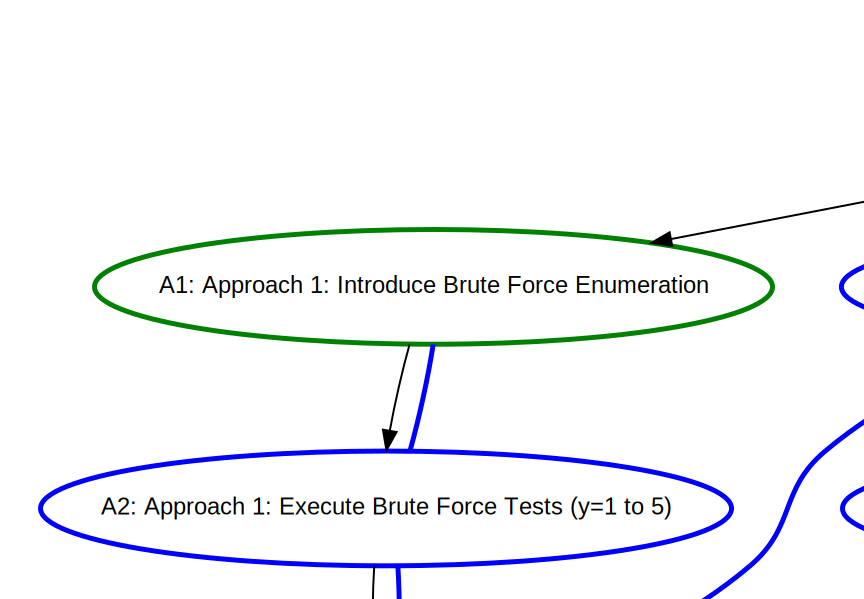

In [30]:
json_data = parse_json(output_json)
visit_order = get_node_visit_order(json_data["logical_flow"])
graph = create_flowchart_from_dict(json_data)
graph = add_highlighted_path(graph, visit_order, color='blue', penwidth='2.5')
graph

In [31]:
graph.render('results/logical_flow_diagram', format='pdf')

'results/logical_flow_diagram.pdf'

In [38]:
from collections import defaultdict
import itertools

def get_trace_by_steps(data: dict) -> list[str]:
    """
    Generates a sequential trace of logical function codes based on the step numbers.

    This function takes a dictionary containing clustering results (mapping function codes
    to step numbers) and generates a list of function codes ordered by the
    sequence of steps (1, 2, 3,...). If a single step number appears in multiple
    function clusters, all corresponding function codes are added to the trace
    for that step number (sorted alphabetically for consistency).

    Args:
        data: A dictionary containing the key 'clustering_results'.
              'clustering_results' should be a dict where keys are function codes (str)
              and values are dicts containing a 'steps' key with a list of
              integers (step numbers). Example:
              {
                  'clustering_results': {
                      'A1': {'description': '...', 'steps': [1, 5]},
                      'A2': {'description': '...', 'steps': [2, 5]},
                      'A3': {'description': '...', 'steps': [3, 5]},
                      'A4': {'description': '...', 'steps': [4, 5, 6]}
                  },
                  'logical_flow': { ... } # Not directly used by this function
              }

    Returns:
        A list of strings, where each string is a function code, ordered
        chronologically by the step numbers they are associated with.
        Returns an empty list if input is invalid or contains no steps.

    Example:
        For the input:
        {'clustering_results': {'A1': {'steps': [1, 5]}, 'A2': {'steps': [2, 5]},
                               'A3': {'steps': [3, 5]}, 'A4': {'steps': [4, 5, 6]}}}
        Output:
        ['A1', 'A2', 'A3', 'A4', 'A1', 'A2', 'A3', 'A4', 'A4']
        (Steps: 1=A1, 2=A2, 3=A3, 4=A4, 5=A1,A2,A3,A4, 6=A4)
    """
    clustering_results = data.get('clustering_results', {})
    if not clustering_results:
        return []

    # 1. Create a mapping from step number to list of function codes
    step_to_nodes = defaultdict(list)
    all_steps = []
    for node_code, details in clustering_results.items():
        steps = details.get('steps', [])
        if not isinstance(steps, list):
            # Handle potential malformed data if 'steps' is not a list
             continue
        for step in steps:
            if isinstance(step, int):
                step_to_nodes[step].append(node_code)
                all_steps.append(step)
            # else: handle non-integer steps if necessary, currently ignored

    if not all_steps:
        return [] # No valid steps found

    # 2. Find the minimum and maximum step number
    min_step = min(all_steps)
    max_step = max(all_steps)

    # 3. Generate the trace by iterating through steps chronologically
    trace = []
    for step_num in range(min_step, max_step + 1):
        # Get nodes associated with the current step, default to empty list
        nodes_for_step = step_to_nodes.get(step_num, [])
        # Sort node codes alphabetically for consistent output when a step is in multiple nodes
        nodes_for_step.sort()
        # Add all nodes for this step to the trace
        trace.extend(nodes_for_step)

    return trace

# Example usage with your provided data:
input_data = {
    'clustering_results': {
        'A1': {'description': 'Calculate Total Revenue (and verify)', 'steps': [1, 5]},
        'A2': {'description': 'Calculate Total Cost (and verify)', 'steps': [2, 5]},
        'A3': {'description': 'Calculate Total Profit (and verify)', 'steps': [3, 5]},
        'A4': {'description': 'Calculate Commission (and verify/confirm)', 'steps': [4, 5, 6]}
    },
    'logical_flow': {
        'root': ['A1'],
        'A1': ['A2'],
        'A2': ['A3'],
        'A3': ['A4'],
        'A4': ['solution']
    }
}

output_trace = get_trace_by_steps(input_data)
print(output_trace)

# Expected output based on your example:
# ['A1', 'A2', 'A3', 'A4', 'A1', 'A2', 'A3', 'A4', 'A4']
# Let's trace manually:
# Step 1: A1 -> ['A1']
# Step 2: A2 -> ['A1', 'A2']
# Step 3: A3 -> ['A1', 'A2', 'A3']
# Step 4: A4 -> ['A1', 'A2', 'A3', 'A4']
# Step 5: A1, A2, A3, A4 -> ['A1', 'A2', 'A3', 'A4', 'A1', 'A2', 'A3', 'A4'] (after sorting)
# Step 6: A4 -> ['A1', 'A2', 'A3', 'A4', 'A1', 'A2', 'A3', 'A4', 'A4']
# The function produces the desired output.

['A1', 'A2', 'A3', 'A4', 'A1', 'A2', 'A3', 'A4', 'A4']
